<a href="https://colab.research.google.com/github/LeonardoClemente23/quarentenadados-Alura/blob/main/QuarentenaDados_Desafio_Final_experiencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 3.3MB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from skopt import dummy_minimize
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [ ]:
# Abrindo arquivos
URI_TREINO    = "https://github.com/tgcsantos/quaretenadados/blob/master/DADOS_TREINO.csv?raw=true"
URI_TESTE     = "https://github.com/tgcsantos/quaretenadados/raw/master/DADOS_TESTE.csv?raw=true"
URI_DESAFIOQT = "https://github.com/tgcsantos/quaretenadados/raw/master/DESAFIOQT.csv?raw=true"

dados_treino  = pd.read_csv(URI_TREINO)
dados_teste   = pd.read_csv(URI_TESTE)
dados_desafio = pd.read_csv(URI_DESAFIOQT)

erro_treino  = "Erro ao carregar dados de treino"
erro_teste   = "Erro ao carregar dados de teste"
erro_desafio = "Erro ao carregar dados de submissão"

assert dados_treino.shape == (150000, 5), erro_treino
assert dados_teste.shape == (20000, 5), erro_teste
assert dados_desafio.shape == (10000, 5), erro_desafio

In [ ]:
# todas as notas menos a nota alvo
features = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']

dados_treino['MEDIAN']  = dados_treino[features].apply(np.median, axis=1)
dados_treino['MIN']     = dados_treino[features].apply(np.min, axis=1)
dados_treino['MAX']     = dados_treino[features].apply(np.max, axis=1)
dados_treino['AVERAGE'] = dados_treino[features].apply(np.average, axis=1)
dados_treino['STD']     = dados_treino[features].apply(np.std, axis=1)

dados_teste['MEDIAN']  = dados_teste[features].apply(np.median, axis=1)
dados_teste['MIN']     = dados_teste[features].apply(np.min, axis=1)
dados_teste['MAX']     = dados_teste[features].apply(np.max, axis=1)
dados_teste['AVERAGE'] = dados_teste[features].apply(np.average, axis=1)
dados_teste['STD']     = dados_teste[features].apply(np.std, axis=1)

dados_desafio['MEDIAN']  = dados_desafio[features].apply(np.median, axis=1)
dados_desafio['MIN']     = dados_desafio[features].apply(np.min, axis=1)
dados_desafio['MAX']     = dados_desafio[features].apply(np.max, axis=1)
dados_desafio['AVERAGE'] = dados_desafio[features].apply(np.average, axis=1)
dados_desafio['STD']     = dados_desafio[features].apply(np.std, axis=1)

In [ ]:
dados_treino

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,MEDIAN,MIN,MAX,AVERAGE,STD
0,530.7,586.5,575.9,539.0,520.0,534.85,520.0,586.5,544.050,25.417169
1,439.4,577.9,440.9,488.7,380.0,464.05,380.0,577.9,471.500,72.490448
2,414.1,548.8,417.2,382.6,600.0,481.45,382.6,600.0,486.375,90.554469
3,407.9,572.7,558.9,595.4,560.0,566.35,407.9,595.4,534.000,73.900034
4,617.2,655.7,564.2,660.9,540.0,636.45,540.0,660.9,618.450,48.336141
...,...,...,...,...,...,...,...,...,...,...
149995,587.8,644.1,621.4,714.4,840.0,679.25,587.8,840.0,696.575,94.172830
149996,385.0,525.6,473.2,446.2,520.0,483.10,385.0,525.6,469.200,57.836494
149997,471.0,558.7,582.4,542.9,460.0,506.95,460.0,558.7,508.150,43.189727
149998,476.7,463.5,553.3,434.0,0.0,448.75,0.0,476.7,343.550,198.950201


In [ ]:
# remove casos de 100% notas zero
dados_treino  = dados_treino.replace(0, np.NaN).dropna(how='all').fillna(0)
dados_teste   = dados_teste.replace(0, np.NaN).dropna(how='all').fillna(0)
dados_desafio = dados_desafio.replace(0, np.NaN).dropna(how='all').fillna(0)

In [ ]:
dados_treino.shape, dados_teste.shape, dados_desafio.shape

((149999, 10), (20000, 10), (10000, 10))

In [ ]:

dados_treino_zeronan       = dados_treino[features].replace(0, np.NaN)
dados_treino['NZ_MEDIAN']  = dados_treino_zeronan[features].apply(np.nanmedian, axis=1)
dados_treino['NZ_MIN']     = dados_treino_zeronan[features].apply(np.nanmin, axis=1)
dados_treino['NZ_AVERAGE'] = dados_treino_zeronan[features].apply(np.nanmean, axis=1)
dados_treino['NZ_STD']     = dados_treino_zeronan[features].apply(np.nanstd, axis=1)

dados_teste_zeronan       = dados_teste[features].replace(0, np.NaN)
dados_teste['NZ_MEDIAN']  = dados_teste_zeronan[features].apply(np.nanmedian, axis=1)
dados_teste['NZ_MIN']     = dados_teste_zeronan[features].apply(np.nanmin, axis=1)
dados_teste['NZ_AVERAGE'] = dados_teste_zeronan[features].apply(np.nanmean, axis=1)
dados_teste['NZ_STD']     = dados_teste_zeronan[features].apply(np.nanstd, axis=1)

dados_desafio_zeronan       = dados_desafio[features].replace(0, np.NaN)
dados_desafio['NZ_MEDIAN']  = dados_desafio_zeronan[features].apply(np.nanmedian, axis=1)
dados_desafio['NZ_MIN']     = dados_desafio_zeronan[features].apply(np.nanmin, axis=1)
dados_desafio['NZ_AVERAGE'] = dados_desafio_zeronan[features].apply(np.nanmean, axis=1)
dados_desafio['NZ_STD']     = dados_desafio_zeronan[features].apply(np.nanstd, axis=1)

In [ ]:
dados_treino.shape, dados_teste.shape, dados_desafio.shape

((149999, 14), (20000, 14), (10000, 14))

In [ ]:
np.random.seed(0)
coluna_target = 'NU_NOTA_LC'
coluna_features = features + ['MEDIAN', 'MIN', 'MAX', 'AVERAGE', 'STD', 'NZ_MEDIAN', 'NZ_MIN', 'NZ_AVERAGE', 'NZ_STD']

selected = np.random.choice(list(range(1,150000)), 20000, replace=False)
X_train = dados_treino.loc[selected, coluna_features]
y_train = dados_treino.loc[selected, coluna_target]

X_train_real = dados_treino[coluna_features]
y_train_real = dados_treino[coluna_target]

X_test = dados_teste[coluna_features]
y_test = dados_teste[coluna_target]

X_desafio = dados_desafio[coluna_features]

# **Otimização de Modelos**



- **Random Forest Regressor**

In [ ]:
modelo_padrao = RandomForestRegressor(n_jobs=-1,random_state=0,)
modelo_padrao.fit(X_train,y_train)
predicao_referencia = modelo_padrao.predict(X_test)

In [ ]:
score_referencia = mean_squared_error(y_test,predicao_referencia)
score_referencia

2217.3399825301503

In [ ]:
def model_trains(params):
  max_depth = params[0] # int
  min_samples_split = params[1] # int or float*
  min_samples_leaf = params[2] # int or float*
  max_leaf_nodes = params[3] # int
  min_impurity_decrease = params[4] # float
  
  print(params,'\n')
  
  modelo = RandomForestRegressor(n_estimators=500, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease,
                                 n_jobs=-1, random_state=0)
  modelo.fit(X_train,y_train)
  
  predicao = modelo.predict(X_test)
  
  return mean_squared_error(y_test,predicao)

intervalos = [(4,10), # max_depth
              (0.05,1.0), # min_samples_split
              (0.05,0.5), # min_samples_leaf
              (2,128), # max_leaf_nodes
              (0.0,1.0)] # min_impurity_decrease

In [ ]:
resultado = dummy_minimize(model_trains, intervalos, random_state=0, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
[9, 0.8520524611519665, 0.4360755279302406, 105, 0.4236547993389048] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.9058
Function value obtained: 5219.2939
Current minimum: 5219.2939
Iteration No: 2 started. Evaluating function at random point.
[9, 0.41516262192806486, 0.18389057294501254, 90, 0.9636627605010295] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 47.8971
Function value obtained: 3123.8931
Current minimum: 3123.8931
Iteration No: 3 started. Evaluating function at random point.
[6, 0.5037818614552824, 0.415475927948972, 48, 0.5680445610939324] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.8938
Function value obtained: 5219.2939
Current minimum: 3123.8931
Iteration No: 4 started. Evaluating function at random point.
[9, 0.8442748253605088, 0.20182827218777077, 22, 0.020218397440325723] 

Iteration No: 4 ended. Evaluation done at random point.

In [ ]:
resultados_gp = gp_minimize(model_trains, intervalos, random_state=0, verbose=1, n_calls=30, n_random_starts=15, x0=[7, 0.24986343302014885, 0.108016833944684, 16, 0.6078306687154679], y0=2457.7879)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0006
Function value obtained: 2457.7879
Current minimum: 2457.7879
Iteration No: 2 started. Evaluating function at random point.
[8, 0.8520524611519666, 0.4360755279302406, 109, 0.6235636967859725] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.8949
Function value obtained: 5219.2939
Current minimum: 2457.7879
Iteration No: 3 started. Evaluating function at random point.
[6, 0.3326578762172487, 0.07552083979284945, 36, 0.47766511732135] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 75.0432
Function value obtained: 2746.4777
Current minimum: 2457.7879
Iteration No: 4 started. Evaluating function at random point.
[9, 0.5059783137563045, 0.22675315824537345, 107, 0.33739616041726844] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 46.5854
Function value obtained: 3123.8931
Current minimum:

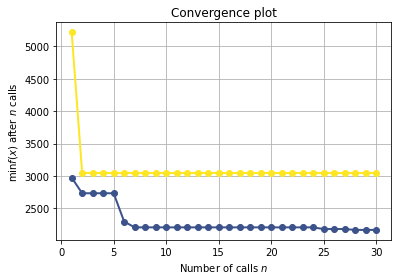

In [ ]:
plot_convergence(resultado,resultados_gp)

In [ ]:
# Aprender a mudar o score ou usá-lo para classificadores. (Consegui!)
from skopt import BayesSearchCV
hp_params_dict = {'max_depth':(4,10),
                     'min_samples_split':(0.05,1.0),
                     'min_samples_leaf':(0.05,0.5),
                     'max_leaf_nodes':(2,128),
                     'min_impurity_decrease': (0.0,1.0)}

opt = BayesSearchCV(RandomForestRegressor(),hp_params_dict,
                    n_jobs=-1,random_state=0, n_iter=30, cv=3, verbose=1,
                    scoring='neg_mean_squared_error')

opt.fit(X_train,y_train)
print(opt.best_estimator_) 
print(opt.best_score_)
print(opt.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=68,
                      max_samples=None,
                      min_impurity_decrease=0.5109967723127247,
                      min_impurity_split=None,
                      min_samples_leaf=0.06228277715000854,
                      min_samples_split=0.10008965505984319,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
-2208.5410531650646
-2230.742867573362


In [ ]:
opt.best_params_

OrderedDict([('max_depth', 7),
             ('max_leaf_nodes', 68),
             ('min_impurity_decrease', 0.5109967723127247),
             ('min_samples_leaf', 0.06228277715000854),
             ('min_samples_split', 0.10008965505984319)])

## Conclusão(Random Forest Regressor): 
Tuning dos hiper parâmetros não funcionou. Com o Random Forest Regressor foi lento e não chegou no resultado desejado. Talvez se limitar mais os parametros, diminuir os intervalos, mas de qualquer jeito é um modelo lento.

- **Gradient Boosting Regressor**

In [ ]:
modelo_padrao2 = GradientBoostingRegressor(random_state=0)
modelo_padrao2.fit(X_train,y_train)
predicao_referencia2 = modelo_padrao2.predict(X_test)

In [ ]:
score_referencia2 = mean_squared_error(y_test,predicao_referencia2)
score_referencia2

2094.9234570653557

In [ ]:
def model_trains2(params):
  learning_rate = params[0]
  min_samples_split = params[1]
  min_samples_leaf = params[2]
  max_depth = params[3]
  alpha = params[4]
  
  print(params,'\n')
  
  modelo = GradientBoostingRegressor(n_estimators=200, max_depth=max_depth,
                                     min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                     learning_rate=learning_rate, alpha=alpha, random_state=0)
  modelo.fit(X_train,y_train)
  
  predicao = modelo.predict(X_test)
  
  return mean_squared_error(y_test,predicao)

intervalos2 = [(0.001,0.01,'log-uniform'), # learning_rate
              (0.25,0.7), # min_samples_split
              (0.05,0.35), # min_samples_leaf
              (3,9), # max_depth
              [0.3,0.4,0.5,0.6,0.7]] # alpha 

hp_params_dict2 = dict(learning_rate = (0.001,0.01,'log-uniform'), min_samples_split = (0.25,0.7), min_samples_leaf = (0.05,0.35), max_depth = (3,9), alpha = [0.3,0.4,0.5,0.6,0.7])

{'alpha': [0.3, 0.4, 0.5, 0.6, 0.7],
 'learning_rate': (0.001, 0.01, 'log-uniform'),
 'max_depth': (3, 9),
 'min_samples_leaf': (0.05, 0.35),
 'min_samples_split': (0.25, 0.7)}

In [ ]:
resultado = dummy_minimize(model_trains2, intervalos2, random_state=0, verbose=1, n_calls=50)

Iteration No: 1 started. Evaluating function at random point.
[0.0039160174486321635, 0.6299195868614578, 0.3073836852868271, 4, 0.6] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 54.2729
Function value obtained: 3158.2933
Current minimum: 3158.2933
Iteration No: 2 started. Evaluating function at random point.
[0.002423157857285798, 0.3838905729450125, 0.06701389319523296, 7, 0.4] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 80.3186
Function value obtained: 3482.6016
Current minimum: 3158.2933
Iteration No: 3 started. Evaluating function at random point.
[0.006190490166774184, 0.488002713888807, 0.2204133683281797, 8, 0.7] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 70.6417
Function value obtained: 2595.9366
Current minimum: 2595.9366
Iteration No: 4 started. Evaluating function at random point.
[0.002174684006048089, 0.5416773424230388, 0.1604724619521644, 8, 0.6] 

Iteration No: 4 ended. Evaluation done at ran

In [ ]:
resultados_gp = gp_minimize(model_trains2, intervalos2, random_state=0, verbose=1, n_calls=30, n_random_starts=15,x0= [0.008339837915839603, 0.28740062168377106, 0.13331556838430975, 3, 0.6], y0=2283.5261)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: 2283.5261
Current minimum: 2283.5261
Iteration No: 2 started. Evaluating function at random point.
[0.0039160174486321635, 0.6299195868614579, 0.3073836852868271, 8, 0.6] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 55.8912
Function value obtained: 3158.2933
Current minimum: 2283.5261
Iteration No: 3 started. Evaluating function at random point.
[0.002423157857285798, 0.3838905729450125, 0.06701389319523296, 5, 0.5] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 83.9587
Function value obtained: 3482.6016
Current minimum: 2283.5261
Iteration No: 4 started. Evaluating function at random point.
[0.006488864850042589, 0.4659897275687758, 0.16783543883024893, 8, 0.4] 

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 78.3351
Function value obtained: 2533.6470
Curren

In [ ]:
from skopt import BayesSearchCV

hp_params_dict2 = dict(learning_rate = (0.001,0.01,'log-uniform'), min_samples_split = (0.25,0.7), min_samples_leaf = (0.05,0.35), max_depth = (3,9), alpha = [0.3,0.4,0.5,0.6,0.7])
opt2 = BayesSearchCV(GradientBoostingRegressor(),hp_params_dict2,
                    n_jobs=-1,random_state=0, n_iter=30, cv=3, verbose=1,
                    scoring='neg_mean_squared_error')

opt2.fit(X_train,y_train)
print(opt2.best_estimator_) 
print(opt2.best_score_)
print(opt2.score(X_test, y_test))
print(opt2.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.3s finished


GradientBoostingRegressor(alpha=0.6, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.00997927745735852,
                          loss='ls', max_depth=5, max_features=None,
                          max_leaf_nodes=None, min_impurity_decrease=0.0,
                          min_impurity_split=None,
                          min_samples_leaf=0.2085628990969996,
                          min_samples_split=0.35817055182063784,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
-2767.8737515651837
-2751.847365287946
OrderedDict([('alpha', 0.6), ('learning_rate', 0.00997927745735852), ('max_depth', 5), ('min_samples_leaf', 0.2085628990969996), ('min_samples_split', 0.35817055182063784)])


## Conclusão(Gradient Boosting Regressor)
O problema não é o modelo, o dataset é muito grande e por isso é lento. Talvez isso seja resolvido diminuindo os dados de treino 

- **XGBRegressor**

In [ ]:
modelo_padrao3 = XGBRegressor(n_jobs=-1,random_state=0,objective='reg:squarederror')
modelo_padrao3.fit(X_train,y_train)
predicao_referencia3 = modelo_padrao3.predict(X_test)

In [ ]:
score_referencia3 = mean_squared_error(y_test,predicao_referencia3)
score_referencia3

2093.2309971404793

In [ ]:
def model_trains3(params):
  learning_rate = params[0]
  gamma = params[1]
  reg_lambda = params[2]
  max_depth = params[3]
  reg_alpha = params[4]

  
  print(params,'\n')
  
  modelo = XGBRegressor(random_state=0, objective='reg:squarederror',
                        learning_rate=learning_rate, gamma=gamma, reg_lambda=reg_lambda,
                        max_depth=max_depth, reg_alpha=reg_alpha, n_jobs=-1)
  modelo.fit(X_train,y_train)
  
  predicao = modelo.predict(X_test)
  
  return mean_squared_error(y_test,predicao)

intervalos3 = [(0.001, 0.1,'log-uniform'), # learning_rate
              (0.0, 1,0), # gamma
              (0.0, 2.0), # reg_lambda
              (1, 10), # max_depth
              (0.0, 1.0)] # reg_alpha

In [ ]:
resultado = dummy_minimize(model_trains3, intervalos3, random_state=0, verbose=1, n_calls=100)

Iteration No: 1 started. Evaluating function at random point.
[0.015335192657991574, 0, 1.715891235245514, 8, 0.4236547993389048] 

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.5727
Function value obtained: 14891.6239
Current minimum: 14891.6239
Iteration No: 2 started. Evaluating function at random point.
[0.019578897201213006, 1, 1.78354600156416, 9, 0.27265629458011326] 

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.0983
Function value obtained: 7495.2549
Current minimum: 7495.2549
Iteration No: 3 started. Evaluating function at random point.
[0.009022569470269151, 0, 0.9599543447501149, 2, 0.9255966382926613] 

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1971
Function value obtained: 48127.3629
Current minimum: 7495.2549
Iteration No: 4 started. Evaluating function at random point.
[0.0013869861245357326, 0.0, 0.040436794880651446, 4, 0.9571551589530466] 

Iteration No: 4 ended. Evaluation done at random po

In [ ]:
# tá dando erro quando começa a otimizar a busca
resultados_gp = gp_minimize(model_trains3, intervalos3, random_state=0, verbose=1, n_calls=30, n_random_starts=15, x0 = [0.1,0.0,1.0,3,0.0], y0=2093.2309971404793)

In [ ]:
import sklearn.metrics as skm
skm.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
# O mesmo erro que comentei acima acontece aqui também. Não sei porque...
SEED_p = 0
np.random.seed(SEED_p)
from skopt import BayesSearchCV
opt = BayesSearchCV(XGBRegressor(objective='reg:squarederror'),
                    {'max_depth':(1, 10),
                     'learning_rate':(0.001, 0.1,'log-uniform'),
                     'reg_lambda':(0.0, 2.0),
                     'gamma':(0.0, 1,0),
                     'reg_alpha': (0.0, 1.0)},
                    n_jobs=-1, n_iter=30, cv=3, verbose=1,scoring='neg_mean_squared_error')

opt.fit(X_train,y_train)
print(opt.best_estimator_) 
print(opt.best_score_)
print(opt.score(X_test, y_test))